In [1]:
import os
import time
from collections import Counter

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Configuration
# -----------------------------------
CONFIG = {
    'DATA_DIR': '/kaggle/input/tomato-leaf-disease-dataset',  # Update this path
    'IMG_SIZE': 224,
    'BATCH_SIZE': 32,
    'LEARNING_RATE': 0.001,
    'WEIGHT_DECAY': 1e-4,
    'EPOCHS': 50,
    'PATIENCE': 10,
    'NUM_CLASSES': 10,
    'CHECKPOINT_DIR': '/kaggle/working/output'
}

os.makedirs(CONFIG['CHECKPOINT_DIR'], exist_ok=True)

os.listdir('/kaggle/working/output')

[]

In [3]:

# Class names for tomato diseases
CLASS_NAMES = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato_Target_Spot',
    'Tomato_Tomato_YellowLeaf_Curl_Virus',
    'Tomato_Tomato_mosaic_virus',
    'Tomato_healthy'
]

class_to_idx = {class_name: idx for idx, class_name in enumerate(CLASS_NAMES)}
idx_to_class = {idx: class_name for idx, class_name in enumerate(CLASS_NAMES)}

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = device.type == 'cuda'
print(f"🚀 Using device: {device}")

# -----------------------------------
# Dataset + Utilities
# -----------------------------------
class TomatoDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = list(image_paths)
        self.labels = list(labels)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            # fallback black image
            print(f"Error loading image {image_path}: {e}")
            image = Image.new('RGB', (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), (0, 0, 0))
        
        label = int(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label

def _normalize_dirname(name):
    # collapse repeated underscores, remove empty parts
    parts = [p for p in name.split('_') if p != '']
    return '_'.join(parts).strip()

def load_dataset(data_dir):
    """Robust loader that tolerates extra underscores in folder names."""
    image_paths = []
    labels = []
    print(f"🍅 Loading tomato dataset from: {data_dir}")
    if not os.path.exists(data_dir):
        print(f"❌ ERROR: Directory {data_dir} does not exist!")
        return np.array([]), np.array([])
    
    all_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    print(f"Found directories: {all_dirs}")
    
    norm_to_actual = {}
    for d in all_dirs:
        norm = _normalize_dirname(d)
        norm_to_actual[norm] = d
    
    expected_norm_to_class = { _normalize_dirname(c): c for c in CLASS_NAMES }
    
    for norm_name, class_name in expected_norm_to_class.items():
        if norm_name in norm_to_actual:
            actual_dir = os.path.join(data_dir, norm_to_actual[norm_name])
            class_images = []
            for ext in ('jpg','jpeg','png','JPG','JPEG','PNG'):
                class_images.extend([f for f in os.listdir(actual_dir) if f.lower().endswith(ext)])
            for img_name in class_images:
                img_path = os.path.join(actual_dir, img_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_to_idx[class_name])
            status = "🟢 HEALTHY" if 'healthy' in class_name.lower() else "🔴 DISEASE"
            print(f"✅ {class_name}: {len(class_images)} images - {status} (from folder: {norm_to_actual[norm_name]})")
        else:
            print(f"❌ Missing directory: {class_name} (expected normalized name: {norm_name})")
    
    extra_dirs = set(all_dirs) - set(norm_to_actual[n] for n in norm_to_actual if n in expected_norm_to_class)
    if extra_dirs:
        print(f"\n📁 Extra directories found (not used): {extra_dirs}")
    
    print(f"\n📈 Dataset Summary:")
    print(f"   Total classes loaded: {len(set(labels))}")
    print(f"   Total images: {len(image_paths)}")
    if labels:
        healthy = sum(1 for label in labels if 'healthy' in CLASS_NAMES[label].lower())
        print(f"   Healthy images: {healthy}")
        print(f"   Disease images: {len(labels) - healthy}")
    return np.array(image_paths), np.array(labels)

# -----------------------------------
# Transforms
# -----------------------------------
def create_transforms():
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(CONFIG['IMG_SIZE'], scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2),
        transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1,0.1))], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02,0.33), ratio=(0.3, 3.3))
    ])
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    return train_transform, val_transform

# -----------------------------------
# Loss
# -----------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, num_classes=10):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss
        return focal_loss.mean()

# -----------------------------------
# Model
# -----------------------------------
class TomatoDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(TomatoDiseaseClassifier, self).__init__()
        # robust EfficientNet loading
        try:
            weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
            self.backbone = models.efficientnet_b0(weights=weights)
        except Exception:
            # fallback older torchvision
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

# -----------------------------------
# Utilities
# -----------------------------------
def calculate_class_weights(labels):
    class_counts = Counter(labels)
    total_samples = len(labels)
    print(f"📊 Class distribution in training set:")
    for class_idx in range(CONFIG['NUM_CLASSES']):
        count = class_counts.get(class_idx, 0)
        class_name = CLASS_NAMES[class_idx]
        print(f"   {class_name}: {count} samples")
    missing_classes = []
    class_weights = {}
    for class_idx in range(CONFIG['NUM_CLASSES']):
        cnt = class_counts.get(class_idx, 0)
        if cnt == 0:
            missing_classes.append(CLASS_NAMES[class_idx])
            class_weights[class_idx] = 1.0
        else:
            class_weights[class_idx] = total_samples / (CONFIG['NUM_CLASSES'] * cnt)
    if missing_classes:
        print(f"⚠️  Warning: Missing classes in training set: {missing_classes}")
        print("   These classes will use default weight of 1.0")
    return torch.FloatTensor([class_weights[i] for i in range(CONFIG['NUM_CLASSES'])])

# -----------------------------------
# Train / Eval
# -----------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_val_acc = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # new amp API
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    print("🚀 Starting training...")
    try:
        for epoch in range(num_epochs):
            epoch_start = time.time()
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print('-' * 60)

            # Training
            model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0
            train_pbar = tqdm(train_loader, desc='Training', leave=False)
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                # autocast new API
                with torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # backward & step with scaler
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                current_acc = correct_predictions / max(total_predictions, 1)
                train_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{current_acc:.4f}'})

            epoch_train_loss = running_loss / max(len(train_loader.dataset), 1)
            epoch_train_acc = correct_predictions / max(total_predictions, 1)
            train_losses.append(epoch_train_loss)
            train_accs.append(epoch_train_acc)

            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc='Validation', leave=False)
                for inputs, labels in val_pbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    with torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_pbar.set_postfix({'Acc': f'{(val_correct/max(val_total,1)):.4f}'})

            epoch_val_loss = val_loss / max(len(val_loader.dataset), 1)
            epoch_val_acc = val_correct / max(val_total, 1)
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            epoch_time = time.time() - epoch_start
            current_lr = optimizer.param_groups[0]['lr']
            # safe GPU mem logging
            if device.type == 'cuda':
                try:
                    gpu_mem = torch.cuda.max_memory_reserved() / (1024**3)
                except Exception:
                    gpu_mem = 0.0
            else:
                gpu_mem = 0.0

            print(f'📊 Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
            print(f'📊 Val   Loss: {epoch_val_loss:.4f}, Val   Acc: {epoch_val_acc:.4f}')
            print(f'⏱️ Epoch time: {epoch_time:.1f}s | LR: {current_lr:.2e} | GPU mem (reserved peak): {gpu_mem:.2f} GB')

            # LR scheduler uses validation loss
            scheduler.step(epoch_val_loss)

            # Save epoch checkpoint
            ckpt = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accs': train_accs,
                'val_accs': val_accs,
                'class_to_idx': class_to_idx,
                'idx_to_class': idx_to_class
            }
            torch.save(ckpt, os.path.join(CONFIG['CHECKPOINT_DIR'], f'ckpt_epoch_{epoch+1}.pth'))

            # Best model
            if epoch_val_acc > best_val_acc:
                best_val_acc = epoch_val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                    'class_to_idx': class_to_idx,
                    'idx_to_class': idx_to_class
                }, os.path.join(CONFIG['CHECKPOINT_DIR'], 'best_tomato_model.pth'))
                print(f'💾 New best model saved! Validation accuracy: {best_val_acc:.4f}')
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= CONFIG['PATIENCE']:
                print(f'⏹️ Early stopping triggered after {epoch+1} epochs')
                break

    except KeyboardInterrupt:
        print("\n🛑 Training interrupted by user — saving current model to 'interrupted_checkpoint.pth' ...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'class_to_idx': class_to_idx,
            'idx_to_class': idx_to_class
        }, os.path.join(CONFIG['CHECKPOINT_DIR'], 'interrupted_checkpoint.pth'))
        print("✅ Saved interrupted checkpoint.")
    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    print("🧪 Evaluating model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
    return accuracy, report, all_predictions, all_labels, np.array(all_probabilities)

# -----------------------------------
# Plots / Reporting (unchanged, safe)
# -----------------------------------
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    ax1.plot(train_losses, label='Training Loss', alpha=0.7)
    ax1.plot(val_losses, label='Validation Loss', alpha=0.7)
    ax1.set_title('Training and Validation Loss'); ax1.legend(); ax1.grid(True, alpha=0.3)
    ax2.plot(train_accs, label='Training Accuracy', alpha=0.7)
    ax2.plot(val_accs, label='Validation Accuracy', alpha=0.7)
    ax2.set_title('Training and Validation Accuracy'); ax2.legend(); ax2.grid(True, alpha=0.3)
    ax3.plot(train_accs, 'b-', alpha=0.7); ax3.fill_between(range(len(train_accs)), train_accs, alpha=0.3)
    ax3.set_title('Training Accuracy Progress'); ax3.grid(True, alpha=0.3)
    final_train_acc = train_accs[-1] if len(train_accs) else 0.0
    final_val_acc = val_accs[-1] if len(val_accs) else 0.0
    ax4.bar(['Training','Validation'], [final_train_acc, final_val_acc], alpha=0.7)
    ax4.set_ylim(0,1)
    ax4.text(0, min(final_train_acc+0.01,0.99), f'{final_train_acc:.3f}', ha='center')
    ax4.text(1, min(final_val_acc+0.01,0.99), f'{final_val_acc:.3f}', ha='center')
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(14,12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[n.replace('Tomato_','').replace('__','_') for n in class_names],
                yticklabels=[n.replace('Tomato_','').replace('__','_') for n in class_names],
                cbar_kws={'label':'Number of Predictions'})
    plt.title('Confusion Matrix - Tomato Disease Classification'); plt.xlabel('Predicted Class'); plt.ylabel('Actual Class')
    with np.errstate(divide='ignore', invalid='ignore'):
        class_accuracies = np.divide(cm.diagonal(), cm.sum(axis=1), out=np.zeros_like(cm.diagonal(), dtype=float), where=cm.sum(axis=1)!=0)
    print("\n📊 Per-class Accuracy:")
    for i, (class_name, acc) in enumerate(zip(class_names, class_accuracies)):
        status = "🟢" if acc > 0.9 else "🟡" if acc > 0.8 else "🔴"
        clean = class_name.replace('Tomato_','').replace('__','_')
        print(f"   {status} {clean}: {acc:.3f}")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_detailed_results(accuracy, report, class_names):
    print("\n🎯 FINAL RESULTS")
    print("="*60)
    print(f"🎯 Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"🎯 90% Target Status: {'✅ TARGET ACHIEVED!' if accuracy>=0.90 else '⚠️ Below 90% target'}")
    print("\n📋 Detailed Classification Report:")
    print("-"*60)
    df_report = pd.DataFrame(report).transpose().round(4)
    for class_name in class_names:
        if class_name in df_report.index:
            clean = class_name.replace('Tomato_','').replace('__','_')
            precision = df_report.loc[class_name,'precision']
            recall = df_report.loc[class_name,'recall']
            f1 = df_report.loc[class_name,'f1-score']
            support = df_report.loc[class_name,'support']
            status = "🟢" if f1>0.9 else "🟡" if f1>0.8 else "🔴"
            health_status = "HEALTHY" if 'healthy' in class_name.lower() else "DISEASE"
            print(f"{status} {clean:30} | P:{precision:.3f} R:{recall:.3f} F1:{f1:.3f} | {health_status:7} | n={support:.0f}")
    print("-"*60)
    if 'macro avg' in df_report.index and 'weighted avg' in df_report.index:
        print(f"📊 Macro Avg    | P:{df_report.loc['macro avg','precision']:.3f} R:{df_report.loc['macro avg','recall']:.3f} F1:{df_report.loc['macro avg','f1-score']:.3f}")
        print(f"📊 Weighted Avg | P:{df_report.loc['weighted avg','precision']:.3f} R:{df_report.loc['weighted avg','recall']:.3f} F1:{df_report.loc['weighted avg','f1-score']:.3f}")


🚀 Using device: cuda


🍅 TOMATO DISEASE CLASSIFICATION
🎯 Target: 90%+ Accuracy
📊 Dataset: tomato-leaf-disease-dataset
🧠 Model: EfficientNet-B0 with Enhanced Head
🍅 Loading tomato dataset from: /kaggle/input/tomato-leaf-disease-dataset
Found directories: ['Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Late_blight', 'Tomato__Tomato_mosaic_virus']
✅ Tomato_Bacterial_spot: 2127 images - 🔴 DISEASE (from folder: Tomato_Bacterial_spot)
✅ Tomato_Early_blight: 1000 images - 🔴 DISEASE (from folder: Tomato_Early_blight)
✅ Tomato_Late_blight: 1909 images - 🔴 DISEASE (from folder: Tomato_Late_blight)
✅ Tomato_Leaf_Mold: 952 images - 🔴 DISEASE (from folder: Tomato_Leaf_Mold)
✅ Tomato_Septoria_leaf_spot: 1771 images - 🔴 DISEASE (from folder: Tomato_Septoria_leaf_spot)
✅ Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images - 🔴 DISEASE (

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 209MB/s]


🧠 Model created: 5.9M parameters
🚀 Starting training...

Epoch 1/50
------------------------------------------------------------


📊 Train Loss: 0.4997, Train Acc: 0.7381
📊 Val   Loss: 0.1837, Val   Acc: 0.8932
⏱️ Epoch time: 68.4s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.8932

Epoch 2/50
------------------------------------------------------------


📊 Train Loss: 0.2858, Train Acc: 0.8300
📊 Val   Loss: 0.0630, Val   Acc: 0.9533
⏱️ Epoch time: 56.5s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9533

Epoch 3/50
------------------------------------------------------------


📊 Train Loss: 0.1691, Train Acc: 0.8892
📊 Val   Loss: 0.0882, Val   Acc: 0.9378
⏱️ Epoch time: 55.8s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 4/50
------------------------------------------------------------


📊 Train Loss: 0.1293, Train Acc: 0.9147
📊 Val   Loss: 0.0425, Val   Acc: 0.9674
⏱️ Epoch time: 55.2s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9674

Epoch 5/50
------------------------------------------------------------


📊 Train Loss: 0.1165, Train Acc: 0.9206
📊 Val   Loss: 0.0475, Val   Acc: 0.9666
⏱️ Epoch time: 54.4s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 6/50
------------------------------------------------------------


📊 Train Loss: 0.1010, Train Acc: 0.9309
📊 Val   Loss: 0.0833, Val   Acc: 0.9449
⏱️ Epoch time: 54.2s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 7/50
------------------------------------------------------------


📊 Train Loss: 0.0866, Train Acc: 0.9400
📊 Val   Loss: 0.0338, Val   Acc: 0.9729
⏱️ Epoch time: 53.8s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9729

Epoch 8/50
------------------------------------------------------------


📊 Train Loss: 0.0888, Train Acc: 0.9403
📊 Val   Loss: 0.0183, Val   Acc: 0.9850
⏱️ Epoch time: 54.1s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9850

Epoch 9/50
------------------------------------------------------------


📊 Train Loss: 0.0830, Train Acc: 0.9477
📊 Val   Loss: 0.0370, Val   Acc: 0.9758
⏱️ Epoch time: 54.1s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 10/50
------------------------------------------------------------


📊 Train Loss: 0.0707, Train Acc: 0.9533
📊 Val   Loss: 0.0397, Val   Acc: 0.9666
⏱️ Epoch time: 53.8s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 11/50
------------------------------------------------------------


📊 Train Loss: 0.0712, Train Acc: 0.9504
📊 Val   Loss: 0.0768, Val   Acc: 0.9457
⏱️ Epoch time: 53.8s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 12/50
------------------------------------------------------------


📊 Train Loss: 0.0644, Train Acc: 0.9579
📊 Val   Loss: 0.0277, Val   Acc: 0.9816
⏱️ Epoch time: 53.5s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 13/50
------------------------------------------------------------


📊 Train Loss: 0.0556, Train Acc: 0.9643
📊 Val   Loss: 0.0514, Val   Acc: 0.9629
⏱️ Epoch time: 53.9s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 14/50
------------------------------------------------------------


📊 Train Loss: 0.0721, Train Acc: 0.9579
📊 Val   Loss: 0.0522, Val   Acc: 0.9662
⏱️ Epoch time: 53.4s | LR: 1.00e-03 | GPU mem (reserved peak): 2.42 GB

Epoch 15/50
------------------------------------------------------------


📊 Train Loss: 0.0411, Train Acc: 0.9775
📊 Val   Loss: 0.0279, Val   Acc: 0.9858
⏱️ Epoch time: 53.9s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9858

Epoch 16/50
------------------------------------------------------------


📊 Train Loss: 0.0441, Train Acc: 0.9778
📊 Val   Loss: 0.0548, Val   Acc: 0.9770
⏱️ Epoch time: 53.6s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 17/50
------------------------------------------------------------


📊 Train Loss: 0.0592, Train Acc: 0.9704
📊 Val   Loss: 0.0362, Val   Acc: 0.9841
⏱️ Epoch time: 53.1s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 18/50
------------------------------------------------------------


📊 Train Loss: 0.0500, Train Acc: 0.9749
📊 Val   Loss: 0.0192, Val   Acc: 0.9917
⏱️ Epoch time: 53.4s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9917

Epoch 19/50
------------------------------------------------------------


📊 Train Loss: 0.0428, Train Acc: 0.9800
📊 Val   Loss: 0.0221, Val   Acc: 0.9917
⏱️ Epoch time: 53.5s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 20/50
------------------------------------------------------------


📊 Train Loss: 0.0414, Train Acc: 0.9826
📊 Val   Loss: 0.0135, Val   Acc: 0.9937
⏱️ Epoch time: 53.4s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9937

Epoch 21/50
------------------------------------------------------------


📊 Train Loss: 0.0463, Train Acc: 0.9821
📊 Val   Loss: 0.0141, Val   Acc: 0.9946
⏱️ Epoch time: 53.8s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9946

Epoch 22/50
------------------------------------------------------------


📊 Train Loss: 0.0387, Train Acc: 0.9842
📊 Val   Loss: 0.0158, Val   Acc: 0.9937
⏱️ Epoch time: 53.8s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 23/50
------------------------------------------------------------


📊 Train Loss: 0.0420, Train Acc: 0.9831
📊 Val   Loss: 0.0309, Val   Acc: 0.9900
⏱️ Epoch time: 53.6s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 24/50
------------------------------------------------------------


📊 Train Loss: 0.0369, Train Acc: 0.9849
📊 Val   Loss: 0.0592, Val   Acc: 0.9879
⏱️ Epoch time: 53.3s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 25/50
------------------------------------------------------------


📊 Train Loss: 0.0324, Train Acc: 0.9880
📊 Val   Loss: 0.0132, Val   Acc: 0.9954
⏱️ Epoch time: 53.9s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9954

Epoch 26/50
------------------------------------------------------------


📊 Train Loss: 0.0380, Train Acc: 0.9866
📊 Val   Loss: 0.0235, Val   Acc: 0.9925
⏱️ Epoch time: 53.7s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 27/50
------------------------------------------------------------


📊 Train Loss: 0.0256, Train Acc: 0.9892
📊 Val   Loss: 0.0260, Val   Acc: 0.9925
⏱️ Epoch time: 53.2s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 28/50
------------------------------------------------------------


📊 Train Loss: 0.0430, Train Acc: 0.9863
📊 Val   Loss: 0.0217, Val   Acc: 0.9942
⏱️ Epoch time: 53.2s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 29/50
------------------------------------------------------------


📊 Train Loss: 0.0356, Train Acc: 0.9880
📊 Val   Loss: 0.0291, Val   Acc: 0.9912
⏱️ Epoch time: 53.1s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 30/50
------------------------------------------------------------


📊 Train Loss: 0.0323, Train Acc: 0.9882
📊 Val   Loss: 0.0108, Val   Acc: 0.9979
⏱️ Epoch time: 53.2s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB
💾 New best model saved! Validation accuracy: 0.9979

Epoch 31/50
------------------------------------------------------------


📊 Train Loss: 0.0277, Train Acc: 0.9906
📊 Val   Loss: 0.0253, Val   Acc: 0.9921
⏱️ Epoch time: 53.1s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 32/50
------------------------------------------------------------


📊 Train Loss: 0.0289, Train Acc: 0.9898
📊 Val   Loss: 0.0357, Val   Acc: 0.9925
⏱️ Epoch time: 53.2s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 33/50
------------------------------------------------------------


📊 Train Loss: 0.0391, Train Acc: 0.9880
📊 Val   Loss: 0.0172, Val   Acc: 0.9946
⏱️ Epoch time: 53.0s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 34/50
------------------------------------------------------------


📊 Train Loss: 0.0271, Train Acc: 0.9902
📊 Val   Loss: 0.0249, Val   Acc: 0.9942
⏱️ Epoch time: 52.9s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 35/50
------------------------------------------------------------


📊 Train Loss: 0.0336, Train Acc: 0.9890
📊 Val   Loss: 0.0189, Val   Acc: 0.9946
⏱️ Epoch time: 53.0s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 36/50
------------------------------------------------------------


📊 Train Loss: 0.0238, Train Acc: 0.9914
📊 Val   Loss: 0.0143, Val   Acc: 0.9950
⏱️ Epoch time: 53.1s | LR: 5.00e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 37/50
------------------------------------------------------------


📊 Train Loss: 0.0185, Train Acc: 0.9938
📊 Val   Loss: 0.0183, Val   Acc: 0.9967
⏱️ Epoch time: 57.6s | LR: 2.50e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 38/50
------------------------------------------------------------


📊 Train Loss: 0.0154, Train Acc: 0.9955
📊 Val   Loss: 0.0121, Val   Acc: 0.9962
⏱️ Epoch time: 53.3s | LR: 2.50e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 39/50
------------------------------------------------------------


📊 Train Loss: 0.0145, Train Acc: 0.9953
📊 Val   Loss: 0.0259, Val   Acc: 0.9942
⏱️ Epoch time: 53.8s | LR: 2.50e-04 | GPU mem (reserved peak): 2.42 GB

Epoch 40/50
------------------------------------------------------------


📊 Train Loss: 0.0186, Train Acc: 0.9938
📊 Val   Loss: 0.0188, Val   Acc: 0.9967
⏱️ Epoch time: 53.6s | LR: 2.50e-04 | GPU mem (reserved peak): 2.42 GB
⏹️ Early stopping triggered after 40 epochs


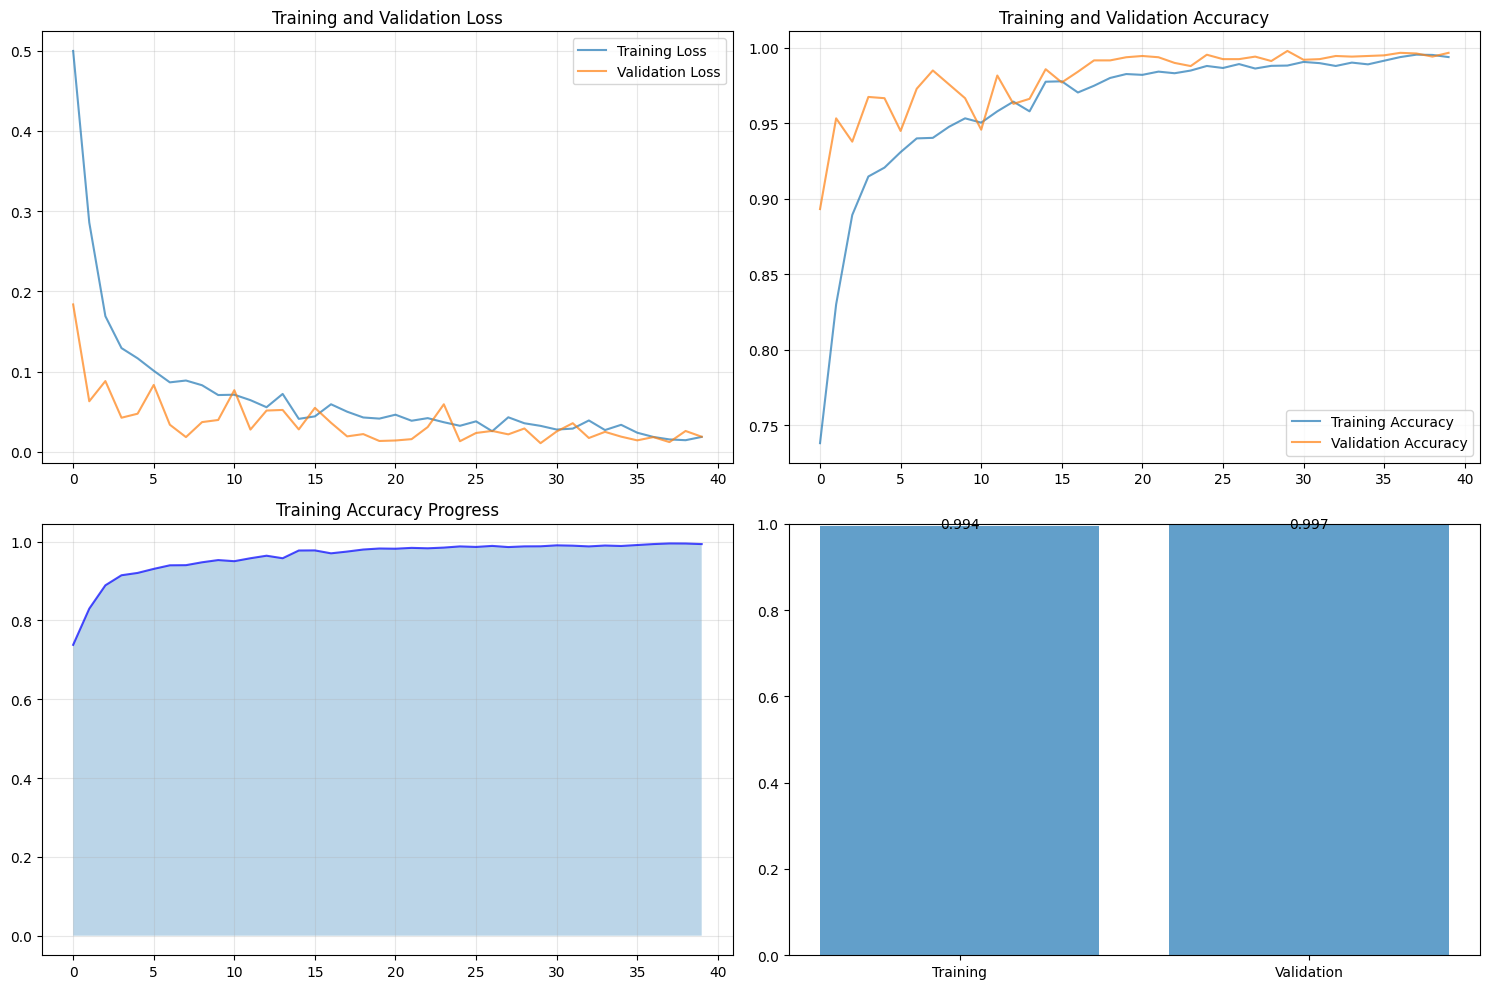


📥 Loading best model for final evaluation...
✅ Best validation accuracy during training: 0.9979
🧪 Evaluating model on test set...


Testing: 100%|██████████| 76/76 [00:08<00:00,  9.01it/s]



🎯 FINAL RESULTS
🎯 Overall Test Accuracy: 0.9942 (99.42%)
🎯 90% Target Status: ✅ TARGET ACHIEVED!

📋 Detailed Classification Report:
------------------------------------------------------------
🟢 Bacterial_spot                 | P:1.000 R:0.991 F1:0.995 | DISEASE | n=319
🟢 Early_blight                   | P:1.000 R:0.973 F1:0.987 | DISEASE | n=150
🟢 Late_blight                    | P:0.997 R:0.997 F1:0.997 | DISEASE | n=286
🟢 Leaf_Mold                      | P:1.000 R:0.972 F1:0.986 | DISEASE | n=143
🟢 Septoria_leaf_spot             | P:0.985 R:1.000 F1:0.993 | DISEASE | n=266
🟢 Spider_mites_Two_spotted_spider_mite | P:0.992 R:1.000 F1:0.996 | DISEASE | n=251
🟢 Target_Spot                    | P:0.991 R:0.991 F1:0.991 | DISEASE | n=211
🟢 YellowLeaf_Curl_Virus          | P:0.998 R:1.000 F1:0.999 | DISEASE | n=481
🟢 mosaic_virus                   | P:0.949 R:1.000 F1:0.974 | DISEASE | n=56
🟢 healthy                        | P:0.996 R:1.000 F1:0.998 | HEALTHY | n=239
---------------------

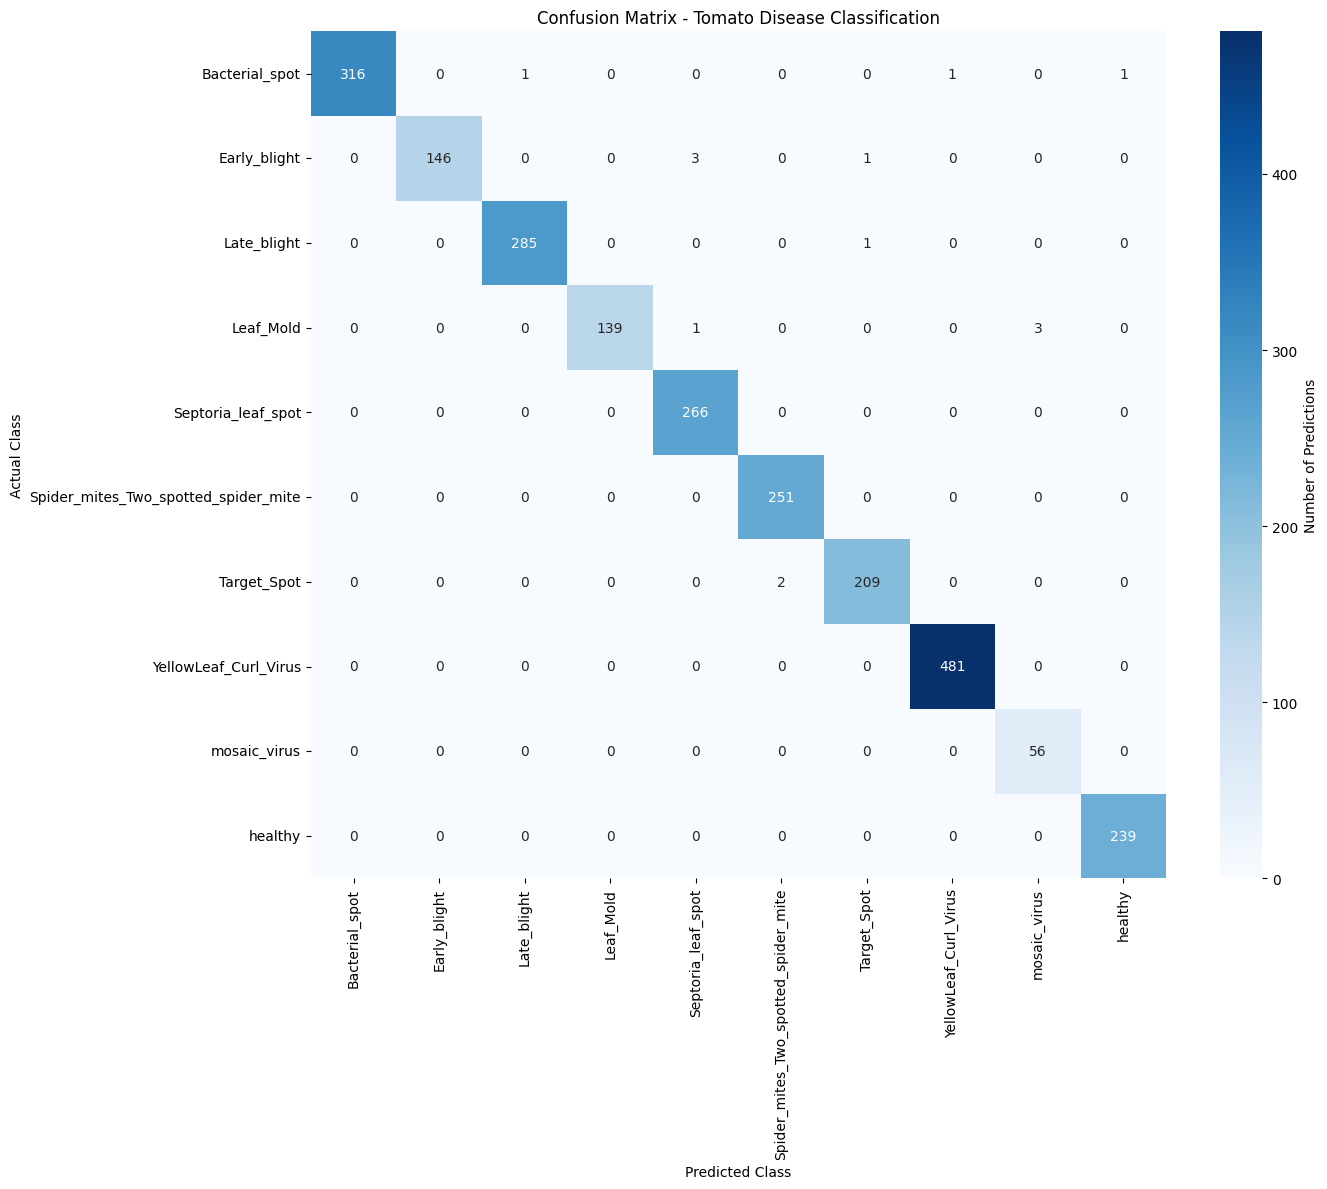


🎉 TRAINING COMPLETED!
🎯 Final Test Accuracy: 0.9942 (99.42%)


In [4]:
def main():
    print("🍅 TOMATO DISEASE CLASSIFICATION")
    print("="*60)
    print("🎯 Target: 90%+ Accuracy")
    print("📊 Dataset: tomato-leaf-disease-dataset")
    print("🧠 Model: EfficientNet-B0 with Enhanced Head")
    print("="*60)
    # load dataset
    image_paths, labels = load_dataset(CONFIG['DATA_DIR'])
    if len(image_paths) == 0:
        print("❌ No images found. Check DATA_DIR and folder names.")
        return
    # stratified split
    print("\n📂 Creating train/validation/test splits...")
    X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.15, stratify=labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)
    print(f"✅ Train samples: {len(X_train)} ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"✅ Validation samples: {len(X_val)} ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"✅ Test samples: {len(X_test)} ({len(X_test)/len(image_paths)*100:.1f}%)")
    # transforms & datasets
    train_transform, val_transform = create_transforms()
    train_dataset = TomatoDataset(X_train, y_train, transform=train_transform)
    val_dataset = TomatoDataset(X_val, y_val, transform=val_transform)
    test_dataset = TomatoDataset(X_test, y_test, transform=val_transform)
    # class imbalance
    class_weights = calculate_class_weights(y_train)
    sample_weights = [class_weights[int(label)].item() for label in y_train]
    sampler = WeightedRandomSampler(weights=torch.as_tensor(sample_weights, dtype=torch.double),
                                    num_samples=len(sample_weights), replacement=True)
    # dataloaders
    try:
        num_workers = min(4, os.cpu_count() or 0)
        pin_memory = device.type == 'cuda'
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], sampler=sampler, num_workers=num_workers, pin_memory=pin_memory)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    except Exception as e:
        print(f"⚠️ DataLoader init error ({e}), falling back to num_workers=0")
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], sampler=sampler, num_workers=0, pin_memory=False)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=0, pin_memory=False)
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=0, pin_memory=False)
    # model, criterion, optimizer, scheduler
    model = TomatoDiseaseClassifier(num_classes=CONFIG['NUM_CLASSES'])
    model = model.to(device)
    print(f"🧠 Model created: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")
    criterion = FocalLoss(alpha=1, gamma=2, num_classes=CONFIG['NUM_CLASSES'])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=CONFIG['WEIGHT_DECAY'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    # train
    train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, CONFIG['EPOCHS'])
    # plots
    if train_losses and val_losses:
        plot_training_history(train_losses, val_losses, train_accs, val_accs)
    # load best model
    print("\n📥 Loading best model for final evaluation...")
    best_ckpt_path = os.path.join(CONFIG['CHECKPOINT_DIR'], 'best_tomato_model.pth')
    if os.path.exists(best_ckpt_path):
        checkpoint = torch.load(best_ckpt_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_val_acc = float(checkpoint.get('best_val_acc', 0.0))
        print(f"✅ Best validation accuracy during training: {best_val_acc:.4f}")
    else:
        print("⚠️ Best model file not found, using current model")
        best_val_acc = val_accs[-1] if val_accs else 0.0
    # final evaluation
    test_accuracy, report, predictions, true_labels, probabilities = evaluate_model(model, test_loader)
    print_detailed_results(test_accuracy, report, CLASS_NAMES)
    plot_confusion_matrix(true_labels, predictions, CLASS_NAMES)
    # save results
    results = {
        'test_accuracy': test_accuracy,
        'best_val_accuracy': best_val_acc,
        'classification_report': report,
        'class_names': CLASS_NAMES,
        'class_to_idx': class_to_idx,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities,
        'config': CONFIG,
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs
        }
    }
    joblib.dump(results, 'tomato_classification_results.pkl')
    print("\n🎉 TRAINING COMPLETED!")
    print("="*60)
    print(f"🎯 Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

if __name__ == "__main__":
    main()
